In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':14})
import cmocean.cm as cm
import os
import re

In [2]:
def plot(path, clean=False):
    path = 'results/' + path
    files = os.listdir(path)
    files = [file for file in files if 'output_' in file]
    
    def get_numbers(filename):
        return [int(n) for n in re.findall(r'\d+', filename)]
    
    files = sorted(files, key=get_numbers)

    runtimes = {}
    for file in files:
        grid_len = file.split('_')[1]
        nproc = file.split('_')[2]
        ntimesteps = int(file.split('_')[3].split('.')[0])
    
        with open(path+file) as f:
            for line in f:
                if 'time for model run:' in line:
                    runtime = float(line.split(':')[1].strip())
    
                    if grid_len not in runtimes:
                        runtimes[grid_len] = {}
                    runtimes[grid_len][f'{nproc}'] = runtime / ntimesteps
                    break
    
    # plot results
    fig, ax = plt.subplots()
    
    for i, key in enumerate(runtimes):
        runtimes_grid = runtimes[f'{key}']
    
        nprocs = [int(nproc) for nproc in runtimes_grid.keys()]
        values = list(runtimes_grid.values())
        ax.plot(nprocs, values, 'o-', color=f'C{i}', label=f'grid length = {key}')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_ylim([0.3,7])
    ax.set_xlabel('Number of cores')
    ax.set_ylabel('Mean time per iteration /s')

    ax.grid(True, which='major')
    ax.grid(True, which='minor', alpha=0.5)

    if not clean:
        ax.legend()

    if clean:
        
        # use this to move the ylabel away from the axis
        ax.set_yticks([1,1])
        ax.set_yticklabels((100,100000), color='white')
        
        # set y tick labels
        for yval, label in zip([0.3, 1, 5], [r'$3 \cdot 10^{-1}$', r'$10^0$', r'$5 \cdot 10^0$']):
            ax.text(
                -0.02, yval, label,
                transform=ax.get_yaxis_transform(),  # aligns to y-axis scale
                ha='right', va='center'
            )

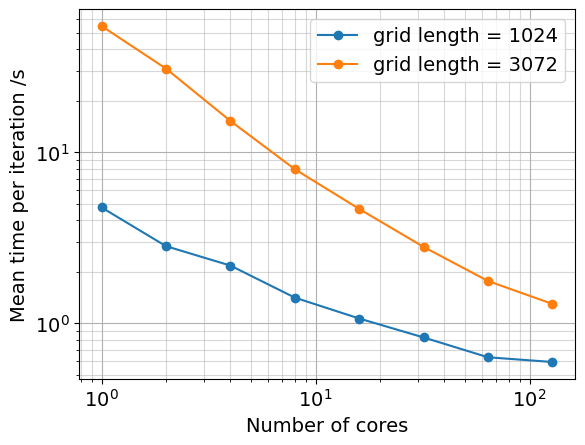

In [3]:
plot('n_nodes_mem_bind_n120/')

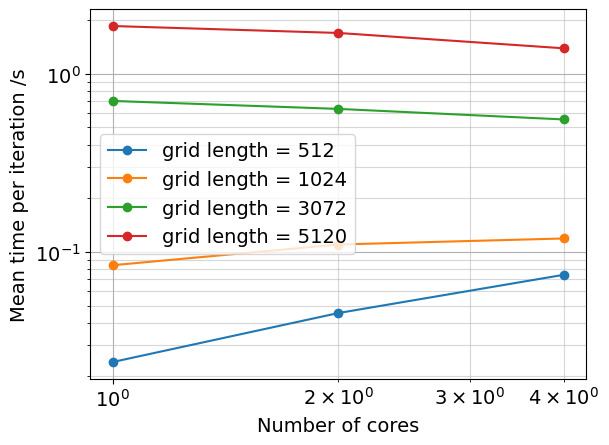

In [4]:
plot('gpu_n120/')

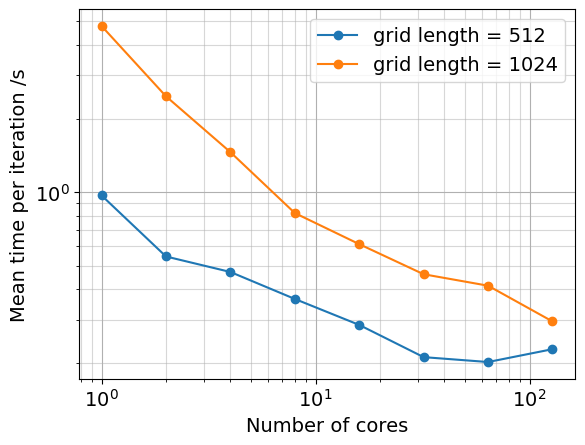

In [5]:
plot('one_node_bcc_mem_bind_n120/')

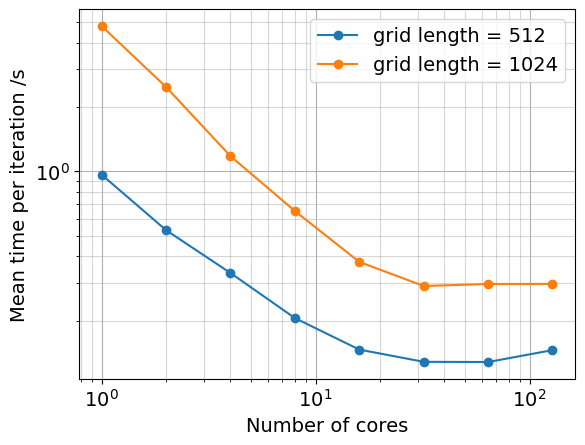

In [6]:
plot('one_node_1proc_in_y_bcc_mem_bind_n120/')

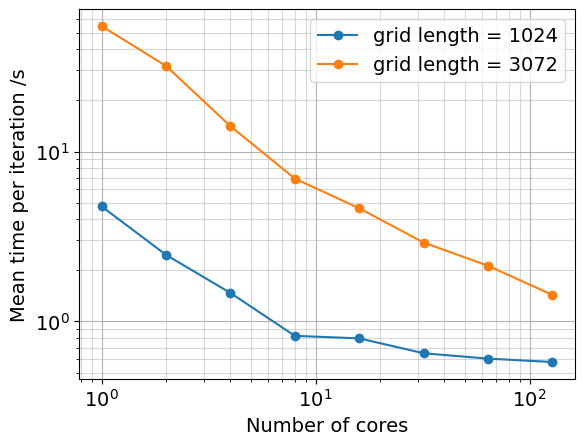

In [7]:
plot('bcc_mem_bind_split_morethan8_n120/')

In [8]:
def gather(path, path_m, path_gpu=None):

    runtimes, runtimes_gpu = {}, {}
    for pth, rtimes in zip([path, path_gpu], [runtimes, runtimes_gpu]):
        ### veris ###
        
        try: pth = 'results/' + pth
        except: continue
        files = os.listdir(pth)
        files = [file for file in files if 'output_' in file]
        
        def get_numbers(filename):
            return [int(n) for n in re.findall(r'\d+', filename)]
        
        files = sorted(files, key=get_numbers)
        
        
        for file in files:
            grid_len = file.split('_')[1]
            nproc = file.split('_')[2]
            ntimesteps = int(file.split('_')[3].split('.')[0])
        
            with open(pth+file) as f:
                for line in f:
                    if 'time for model run:' in line:
                        runtime = float(line.split(':')[1].strip())
        
                        if grid_len not in rtimes:
                            rtimes[grid_len] = {}
                        rtimes[grid_len][f'{nproc}'] = runtime / ntimesteps
                        break

    ### mitgcm ###
    
    itimes = {}
    
    files = os.listdir(path_m)
    files = [file for file in files if 'output_' in file]
    def get_numbers(filename):
        return [int(n) for n in re.findall(r'\d+', filename)]
    files = sorted(files, key=get_numbers)
    
    search_for="SEAICE_MODEL    [DO_OCEANIC_PHYS]"
    for file in files:
        grid_len = file.split('_')[1]
        nproc = int(file.split('_')[2])
    
        with open(path_m + file) as f:
            
            lines = f.readlines()
            for i, line in enumerate(lines):
                if line.find("nTimeSteps = ") != -1:
                    ntimesteps_line = lines[i+1]
                if line.find(search_for) != -1:
                    wall_clock_line = lines[i+3]
        
        ntimesteps = int(ntimesteps_line[:-1].split(' ')[-1])
        wall_clock_time = float(wall_clock_line[:-1].split(' ')[-1])
    
        if grid_len not in itimes:
            itimes[grid_len] = {}
        
        itimes[grid_len][f'{nproc}'] = wall_clock_time / ntimesteps

    
    ### plot results ###
    
    fig, ax = plt.subplots()

    colors = ['royalblue', 'blue', 'darkorange', 'red', 'gray', 'dimgrey', 'black', 'black']
    
    # plot veris
    for i, key in enumerate(runtimes):
        #if i==0: continue
        runtimes_grid = runtimes[f'{key}']
    
        nprocs = [int(nproc) for nproc in runtimes_grid.keys()]
        values = list(runtimes_grid.values())
        ax.plot(nprocs, values, 'o-', color=f'{colors[i]}', label=f'Veris, grid length = {key}')

    # plot mitgcm
    for i, key in enumerate(itimes):
        #if i==0: continue
        runtimes_grid = itimes[f'{key}']
    
        nprocs = [int(nproc) for nproc in runtimes_grid.keys()]
        values = list(runtimes_grid.values())
        ax.plot(nprocs, values, 'o-', color=f'{colors[i+2]}', label=f'MITgcm, grid length = {key}')

    # plot veris gpu
    for i, key in enumerate(runtimes_gpu):
        runtimes_grid = runtimes_gpu[f'{key}']
    
        nprocs = [int(nproc) for nproc in runtimes_grid.keys()]
        values = list(runtimes_grid.values())
        ax.plot(nprocs, values, 'o-', color=f'{colors[i+4]}', label=f'Veris GPU, grid length = {key}')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of cores')
    ax.set_ylabel('Mean time per iteration /s')
    
    ax.grid(True, which='major')
    ax.grid(True, which='minor', alpha=0.5)
    ax.legend(bbox_to_anchor=(1,1))

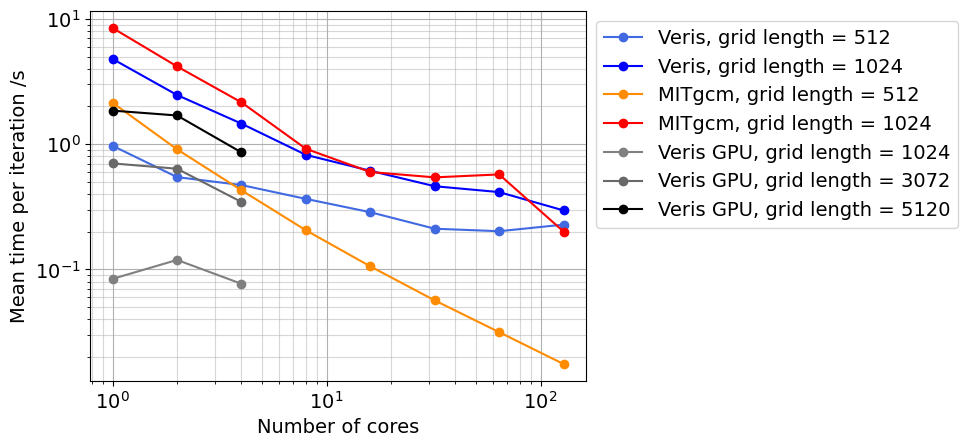

In [9]:
gather('one_node_bcc_mem_bind_n120/',
       '/home/a/a270230/benchmarks/mitgcm_benchmarks/benchmark_results/parallel/one_node_n120/',
      'gpu_1proc_in_y_n120/')
#plt.savefig('single_node_all_gpu_larger.png', dpi=300, bbox_inches='tight')

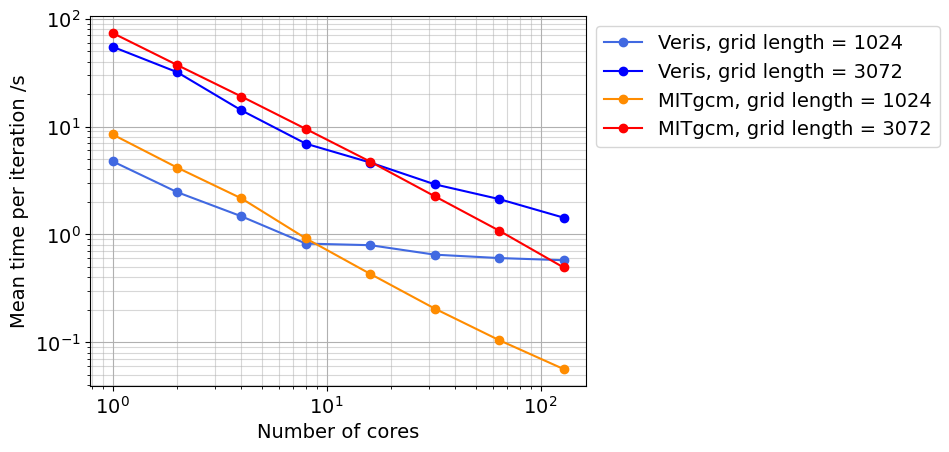

In [10]:
gather('bcc_mem_bind_split_morethan8_n120/',
      '/home/a/a270230/benchmarks/mitgcm_benchmarks/benchmark_results/parallel/split_morethan8_n120/')
#plt.savefig('more_nodes.png', dpi=300, bbox_inches='tight')

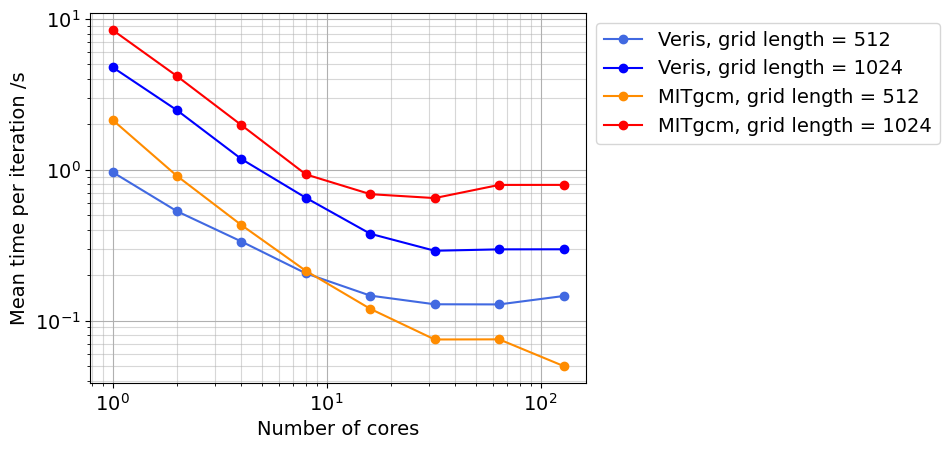

In [11]:
gather('one_node_1proc_in_y_bcc_mem_bind_n120/',
       '/home/a/a270230/benchmarks/mitgcm_benchmarks/benchmark_results/parallel/one_node_1proc_in_y_n120/',
      )#'results_gpu_n120/')

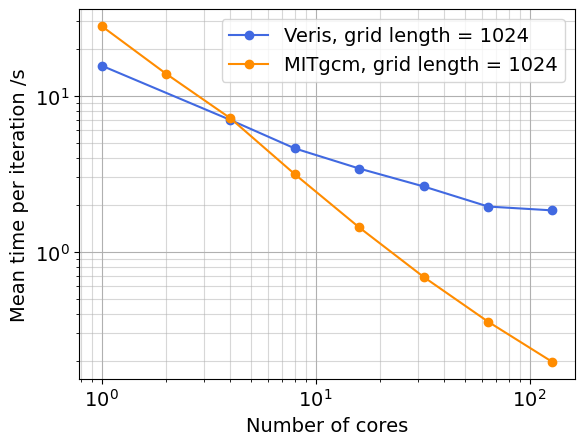

In [12]:
gather('n_nodes/',
       '/home/a/a270230/benchmarks/mitgcm_benchmarks/benchmark_results_save/parallel/')